<a href="https://colab.research.google.com/github/egornekr/study_projects/blob/main/Test_task_MAXIMUM_NekrasovEV_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Задание по анализу данных автодилера** (Некрасов Е.В.) 2022

# Описание проекта
В данном проекте мы производим анализ зависимости количества обращений с каналов органики от спроса ( частотности запросов в вордстате). В нашем распоряжении данные о двух автомобильных брендах - количества обращений и запросов по органическим каналам. Нам необходимо узнать, наблюдается ли такая зависимость и оценить ее качественно.

In [1]:
!pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 696 kB 4.1 MB/s 


In [2]:
# импортируем библиотеки
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from scipy.stats import spearmanr
from scipy.stats import shapiro

In [53]:
# устанавливаем параметры
'''
db_config = {'user': '******', # имя пользователя
'pwd': '******', # пароль
'host': '*****',
'port': 15432, # порт подключения
'db': '***' # название базы данных
}
connection_string = 'postgresql://{user}:{pwd}@{host}:{port}/{db}'.format(**db_config)
# сохраняем коннектор
engine = create_engine(connection_string)
'''

"\ndb_config = {'user': '******', # имя пользователя\n'pwd': '******', # пароль\n'host': '*****',\n'port': 15432, # порт подключения\n'db': '***' # название базы данных\n}\nconnection_string = 'postgresql://{user}:{pwd}@{host}:{port}/{db}'.format(**db_config)\n# сохраняем коннектор\nengine = create_engine(connection_string)\n"

# Загрузка данных и предобработка

In [52]:
# узнаем размер предоставленной бд

query = '''
         SELECT pg_size_pretty(pg_database_size(current_database()));

      '''

pd.io.sql.read_sql(query, con = engine)

IndentationError: ignored

In [5]:
# посмотрим моих конкурентов😁
query = '''
         SELECT DISTINCT(usename) FROM pg_stat_activity;

      '''

pd.io.sql.read_sql(query, con = engine)

,usename
0,None
1,evgeniya_poddubnaya
2,egor_nekrasov
3,ruslan_khadzhimustafov
4,aleksandr_rogozhnikov
5,armine_agadzhanyan
6,georgiy_ilin
7,secret_root


In [6]:
# посмотрим какие еще таблицы есть в бд
query = '''
        SELECT table_name FROM information_schema.tables
        WHERE table_schema NOT IN ('information_schema','pg_catalog');

      '''

pd.io.sql.read_sql(query, con = engine)

,table_name
0,communications


In [50]:
# прочитаем данные о коммуникациях
try:
  communications = pd.read_csv('/content/communications', sep = ';')

except:
  url='https://drive.google.com/file/d/13SczzSCZZc8Oy91anJg3-wAjQ5D1aMUJ/view?usp=share_link'
  url='https://drive.google.com/uc?id=' + url.split('/')[-2]
  communications = pd.read_csv(url, sep = '\t')

communications



,Unnamed: 0,communication_id,date_time,brand_id,source_type,date
0,0,11394944,2021-06-01 00:41:20.000,1,other,2021-06-01
1,1,11395343,2021-06-01 01:33:09.000,1,other,2021-06-01
2,2,11397299,2021-06-01 06:02:29.000,1,other,2021-06-01
3,3,1656035517,2021-06-01 06:09:14.000,0,other,2021-06-01
4,4,11397353,2021-06-01 06:13:20.000,1,other,2021-06-01
...,...,...,...,...,...,...
25157,25157,1825329504,2021-08-31 21:26:56.000,0,other,2021-08-31
25158,25158,12819752,2021-08-31 21:35:09.000,1,other,2021-08-31
25159,25159,1748727061,2021-08-31 21:40:38.000,1,other,2021-08-31
25160,25160,1630437872112,2021-08-31 22:20:38.000,1,other,2021-08-31


In [8]:
# прочитаем данные о поисковых фразах (я работал в коллабе, чтобы вам не менять путь до локального файла
# я добавил ссылку на него с гугл диска)
try:
  phrases = pd.read_csv('/content/phrases_shows.csv', sep = ';',parse_dates=['date'])

except:
  url='https://drive.google.com/file/d/1ID07l9Vw74qKw3ObDdKX0LIswF9K936u/view?usp=drivesdk'
  url='https://drive.google.com/uc?id=' + url.split('/')[-2]
  phrases = pd.read_csv(url, sep = ';',parse_dates=['date'])

phrases

,date,brand_id,phrase_id,shows
0,2021-06-01,0,0,576
1,2021-06-01,0,1,90
2,2021-06-01,0,2,55
3,2021-06-01,0,3,144
4,2021-06-01,0,4,8
...,...,...,...,...
2663,2021-08-31,1,42,1075
2664,2021-08-31,1,43,86
2665,2021-08-31,1,44,88
2666,2021-08-31,1,45,930


In [9]:
# проверим на пропуски и типы данных
communications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25162 entries, 0 to 25161
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   communication_id  25162 non-null  int64         
 1   date_time         25162 non-null  datetime64[ns]
 2   brand_id          25162 non-null  int64         
 3   source_type       25162 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 786.4+ KB


In [10]:
communications.describe()

,communication_id,brand_id
count,2.516200e+04,25162.000000
mean,7.092880e+12,0.551586
std,1.143933e+14,0.497342
min,1.139494e+07,0.000000
25%,1.662419e+09,0.000000
50%,1.710115e+09,1.000000
75%,1.768863e+09,1.000000
max,4.628807e+15,1.000000


Имеем два бренда и коммуникации по ним разделены поровну, не очень похоже на правду, но что имеем.

In [11]:
# проверим на явные дубликаты
communications.duplicated().sum()

0

In [12]:
# посмотрим какие типы каналов предусмотрены в нашей базе данных
communications['source_type'].unique()

array(['other', 'organic'], dtype=object)

In [13]:
# создадим новый столбец с датой (округлим время комуникации до даты (отбросим время))
communications['date'] = communications['date_time'].dt.date

# создадим датафрейм в котором будет только органические коммуникации
communications_organic = communications[communications['source_type'] == 'organic']

# создадим сводную таблицу и посчитаем количество комуникаций по датам и брендам
t = communications_organic.groupby(['date','brand_id'])['communication_id'].agg(['count']).reset_index()

# дату приведём к нужному виду
t['date'] = pd.to_datetime(t['date'])
t = t.rename(columns = {'count':'communication_count'})
t.head(5)

,date,brand_id,communication_count
0,2021-06-01,0,3
1,2021-06-01,1,15
2,2021-06-02,0,5
3,2021-06-02,1,7
4,2021-06-03,0,5


In [14]:
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 183 non-null    datetime64[ns]
 1   brand_id             183 non-null    int64         
 2   communication_count  183 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.4 KB


In [15]:
# проверим на пропуски и типы данных
phrases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2668 entries, 0 to 2667
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       2668 non-null   datetime64[ns]
 1   brand_id   2668 non-null   int64         
 2   phrase_id  2668 non-null   int64         
 3   shows      2668 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 83.5 KB


In [16]:
# проверим на явные дубликаты
phrases.duplicated().sum()

0

In [17]:
# так как нас не интересует зависимость от конкретных поисковых фраз в разрезе бренда,
# просуммируем запросы в день по каждому бренду
t2 = phrases.groupby(['date',	'brand_id'])['shows'].agg(['sum']).reset_index()

# переименуем столбец с суммой

t2 = t2.rename(columns = {'sum':'sum_shows'})
t2

,date,brand_id,sum_shows
0,2021-06-01,0,11590
1,2021-06-01,1,32641
2,2021-06-02,0,11533
3,2021-06-02,1,32649
4,2021-06-03,0,11615
...,...,...,...
179,2021-08-29,1,47030
180,2021-08-30,0,17136
181,2021-08-30,1,46341
182,2021-08-31,0,17107


In [18]:
# совместим два датафрейма
df = pd.merge(t2,t, on = ['date', 'brand_id'], how='left')
df

,date,brand_id,sum_shows,communication_count
0,2021-06-01,0,11590,3.0
1,2021-06-01,1,32641,15.0
2,2021-06-02,0,11533,5.0
3,2021-06-02,1,32649,7.0
4,2021-06-03,0,11615,5.0
...,...,...,...,...
179,2021-08-29,1,47030,2.0
180,2021-08-30,0,17136,5.0
181,2021-08-30,1,46341,9.0
182,2021-08-31,0,17107,8.0


In [19]:
df.describe()

,brand_id,sum_shows,communication_count
count,184.000000,184.000000,183.000000
mean,0.500000,26078.826087,7.590164
std,0.501364,11783.950285,4.133927
min,0.000000,11533.000000,1.000000
25%,0.000000,14841.750000,5.000000
50%,0.500000,25124.000000,7.000000
75%,1.000000,33808.000000,10.000000
max,1.000000,47030.000000,21.000000


## Выявление аномалий

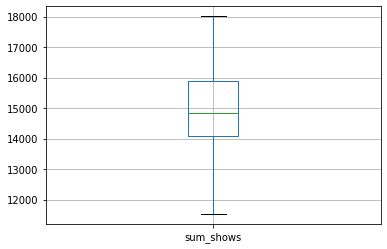

In [20]:
# распределение показов для бренда 0
df[df['brand_id'] == 0].boxplot(column=['sum_shows']) 

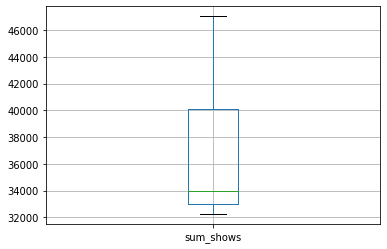

In [21]:
# распределение показов для бренда 1
df[df['brand_id'] == 1].boxplot(column=['sum_shows']) 

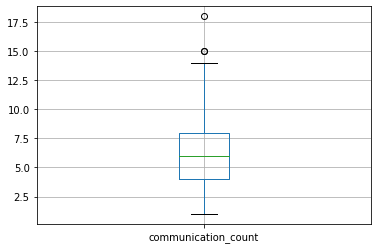

In [22]:
# распределение коммуникаций для бренда 0
df[df['brand_id'] == 0].boxplot(column=['communication_count']) 

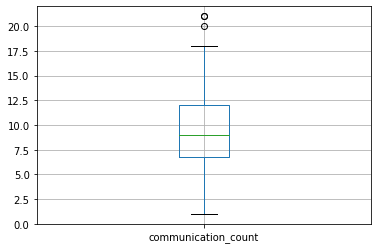

In [23]:
# распределение коммуникаций для бренда 1
df[df['brand_id'] == 1].boxplot(column=['communication_count']) 

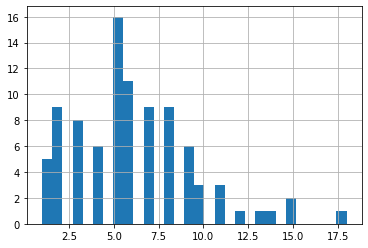

In [24]:
# посмотрим на распределения количества коммуникаций бренда "0"
df[df['brand_id'] == 0]['communication_count'].hist(bins = 30)

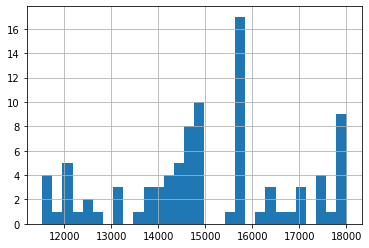

In [25]:
# посмотрим на распределения количества показов бренда "0"
df[df['brand_id'] == 0]['sum_shows'].hist(bins = 30)

В количестве показов есть выбросы

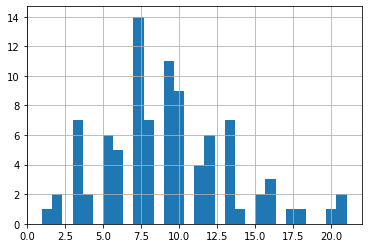

In [26]:
# посмотрим на распределения количества коммуникаций бренда "1"
df[df['brand_id'] == 1]['communication_count'].hist(bins = 30)

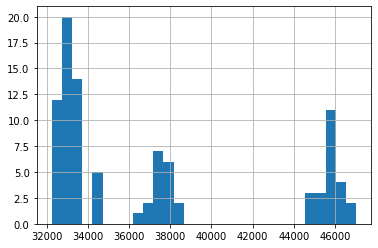

In [27]:
# посмотрим на распределения количества показов бренда "1"
df[df['brand_id'] == 1]['sum_shows'].hist(bins = 30)

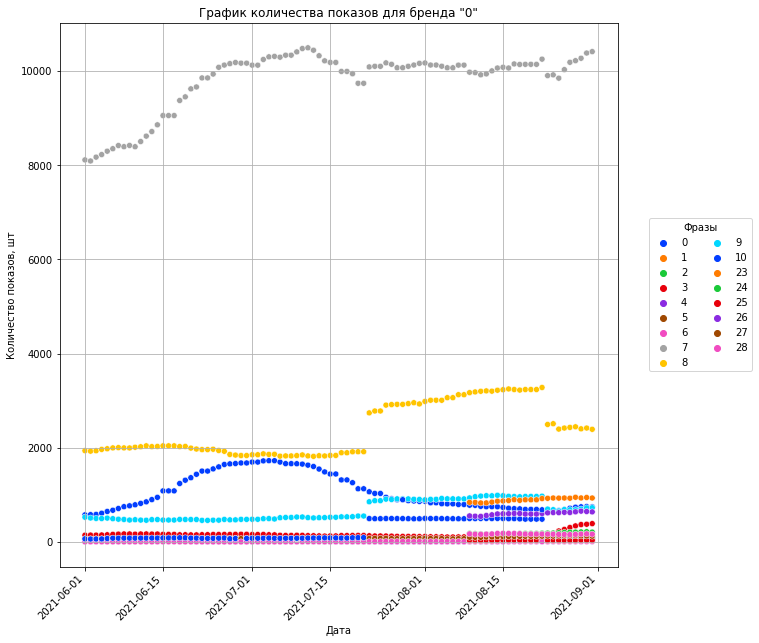

In [28]:
# построим график количества показов по каждому поисковому запросу
fig = plt.gcf()


fig.set_size_inches(10, 10)
sns.scatterplot(
    x='date',
    y='shows', 
    data=phrases[phrases['brand_id'] == 0],
    palette='bright',
    hue = 'phrase_id').legend(loc='right',title = 'Фразы', bbox_to_anchor=(1.25, 0.5), ncol=2)

plt.title('График количества показов для бренда "0"')
plt.xlabel('Дата')
plt.ylabel('Количество показов, шт')
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light')
plt.grid()
plt.show()

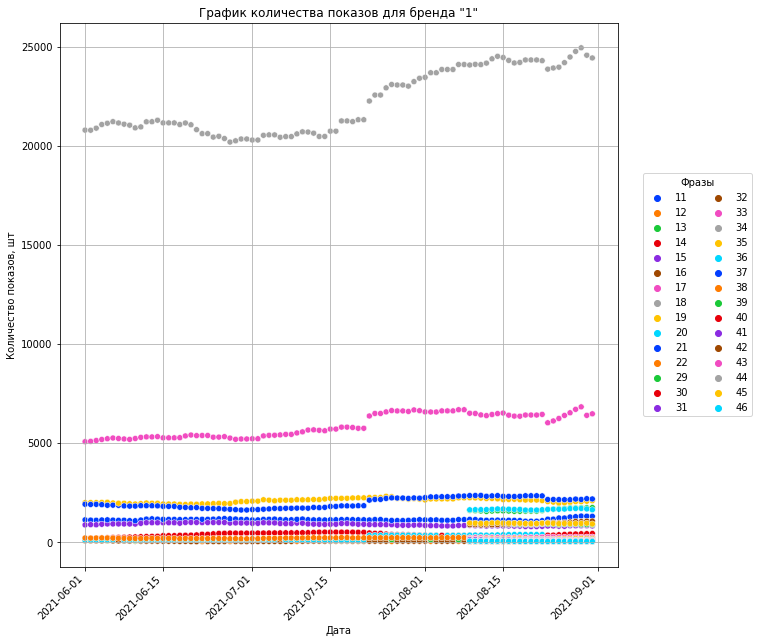

In [29]:
fig = plt.gcf()


fig.set_size_inches(10, 10)
sns.scatterplot(
    x='date',
    y='shows', 
    data=phrases[phrases['brand_id'] == 1],
    palette='bright',
    hue = 'phrase_id').legend(loc='right', title = 'Фразы', bbox_to_anchor=(1.25, 0.5), ncol=2)

plt.title('График количества показов для бренда "1"')
plt.xlabel('Дата')
plt.ylabel('Количество показов, шт')
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light')
plt.grid()
plt.show()

## Выводы по предобработке:

* Пропусков, повторов и проблем с типами данных не обнаружено
* В количестве коммуникаций по дням есть выбросы, но субьективно небольшие, принимаем решение оставить эти данные в датасете
* по некоторым поисковым фразам наблюдаются резкие скачки частотности (например 8)
* по бренду "1" частотность запросов выше примерно в 2 раза (чем по бренду "0")
* по обоим брендам есть высокочастотные запросы, отличающиеся от остальных по частотности в 4-5 раз ( 7 и 44 )
* у бренда "0" 17 поисковых фраз, а у бренда "1" - 30 

# Построение графиков

In [30]:
df.head()

,date,brand_id,sum_shows,communication_count
0,2021-06-01,0,11590,3.0
1,2021-06-01,1,32641,15.0
2,2021-06-02,0,11533,5.0
3,2021-06-02,1,32649,7.0
4,2021-06-03,0,11615,5.0


In [31]:
# так как данные по показам у нас за предыдущий месяц, а коммуникации за текущий,
# сместим колонку с показами на 1 вниз
df['sum_shows'] = df['sum_shows'].shift(2)
df.head(10)

,date,brand_id,sum_shows,communication_count
0,2021-06-01,0,NaN,3.0
1,2021-06-01,1,NaN,15.0
2,2021-06-02,0,11590.0,5.0
3,2021-06-02,1,32641.0,7.0
4,2021-06-03,0,11533.0,5.0
5,2021-06-03,1,32649.0,9.0
6,2021-06-04,0,11615.0,2.0
7,2021-06-04,1,32784.0,13.0
8,2021-06-05,0,11725.0,6.0
9,2021-06-05,1,33072.0,3.0


In [32]:
# удалим нули
df = df.dropna()
df

,date,brand_id,sum_shows,communication_count
2,2021-06-02,0,11590.0,5.0
3,2021-06-02,1,32641.0,7.0
4,2021-06-03,0,11533.0,5.0
5,2021-06-03,1,32649.0,9.0
6,2021-06-04,0,11615.0,2.0
...,...,...,...,...
179,2021-08-29,1,46735.0,2.0
180,2021-08-30,0,16955.0,5.0
181,2021-08-30,1,47030.0,9.0
182,2021-08-31,0,17136.0,8.0


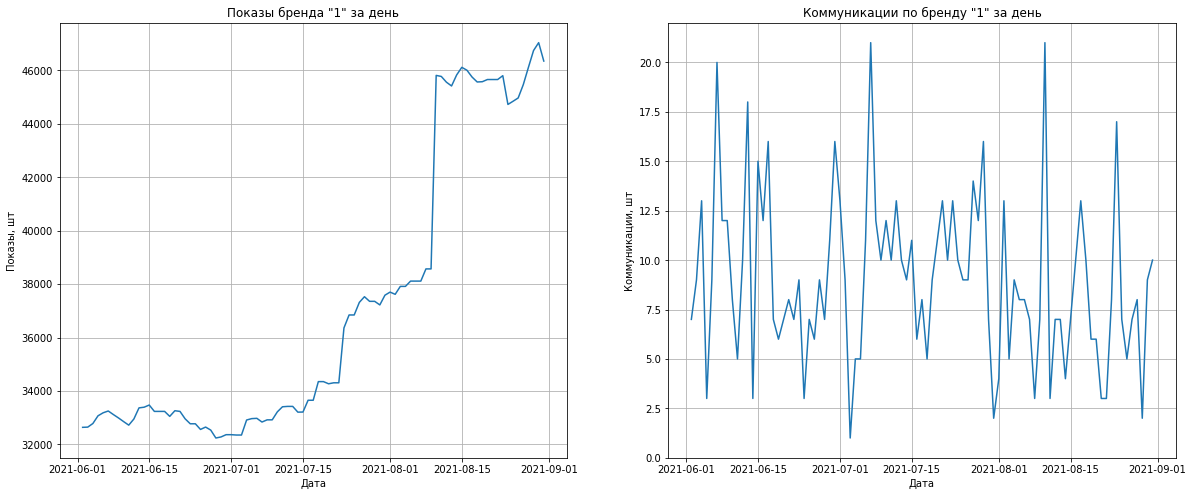

In [33]:
# графики
fig, ax =plt.subplots(1,2)
sns.lineplot(data=df[df['brand_id'] == 1], x="date", y='sum_shows', ax=ax[0])
sns.lineplot(data=df[df['brand_id'] == 1], x="date", y='communication_count', ax=ax[1])
fig.set_figheight(8)
fig.set_figwidth(20)


# красота
ax[0].set_title('Показы бренда "1" за день')
ax[0].set_xlabel('Дата')
ax[0].set_ylabel('Показы, шт')
ax[0].grid(True)
ax[1].set_title('Коммуникации по бренду "1" за день')
ax[1].set_xlabel('Дата')
ax[1].set_ylabel('Коммуникации, шт')
ax[1].grid(True)


plt.show()

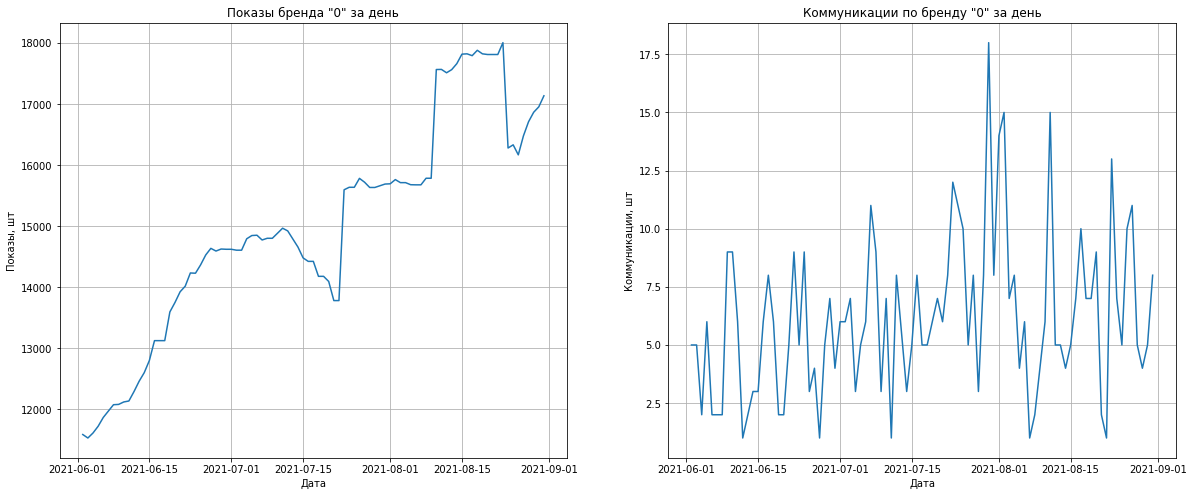

In [34]:
# графики
fig, ax =plt.subplots(1,2)
sns.lineplot(data=df[df['brand_id'] == 0], x="date", y='sum_shows', ax=ax[0])
sns.lineplot(data=df[df['brand_id'] == 0], x="date", y='communication_count', ax=ax[1])
fig.set_figheight(8)
fig.set_figwidth(20)


# красота
ax[0].set_title('Показы бренда "0" за день')
ax[0].set_xlabel('Дата')
ax[0].set_ylabel('Показы, шт')
ax[0].grid(True)
ax[1].set_title('Коммуникации по бренду "0" за день')
ax[1].set_xlabel('Дата')
ax[1].set_ylabel('Коммуникации, шт')
ax[1].grid(True)


plt.show()

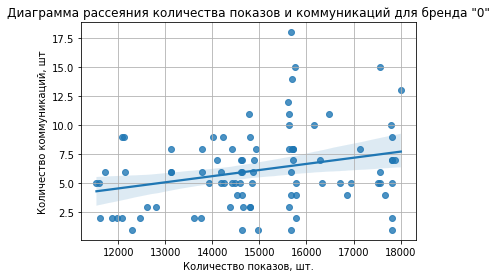

In [35]:
# построим диаграмму рассеяния для бренда "0" с линией регрессии
sns.regplot(
    x='sum_shows', 
    y='communication_count', 
    data=df[df['brand_id'] == 0])
plt.xlabel(
    'Количество показов, шт.')
plt.ylabel(
    'Количество коммуникаций, шт')
plt.title('Диаграмма рассеяния количества показов и коммуникаций для бренда "0"')
plt.grid()
plt.show()

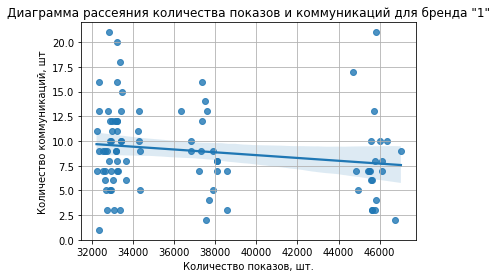

In [36]:
# построим диаграмму рассеяния для бренда "1" с линией регрессии
sns.regplot(
    x='sum_shows', 
    y='communication_count', 
    data=df[df['brand_id'] == 1])
plt.xlabel(
    'Количество показов, шт.')
plt.ylabel(
    'Количество коммуникаций, шт')
plt.title('Диаграмма рассеяния количества показов и коммуникаций для бренда "1"')
plt.grid()
plt.show()



*   По обоим брендам наблюдаем рост показов органической выдачи
*   По обоим брендам наблюдаем резкие скачки показов органической выдачи, возможно они вызваны рекламными кампаниями брендов, анонсами новых моделей или другими действиями повышающими интерес к бренду
* По графикам количества коммуникаций наблюдаем шум, из за этого сложно оценить тренд
* Можно предположить, что у обоих брендов есть зависимость количества коммуникаций от количества показов
* Наблюдается "квантование" количества показов для бренда 1, что показывает сильное влияние скачков высокочастотных запросов


Попробуем сгладить графики коммуникаций с помощью скользящего среднего

In [37]:
# создадим отделльные датафреймы для каждого бренда
df_1 = df[df['brand_id'] == 1]
df_0 = df[df['brand_id'] == 0]

# сгладим значения количества коммуникаций с помощью скользящего среднего
df_1['filtered_communication_count'] = df_1['communication_count'].rolling(14).mean()
df_0['filtered_communication_count'] = df_0['communication_count'].rolling(14).mean()

<ipython-input-37-8f7ab304e99e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['filtered_communication_count'] = df_1['communication_count'].rolling(14).mean()
<ipython-input-37-8f7ab304e99e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['filtered_communication_count'] = df_0['communication_count'].rolling(14).mean()


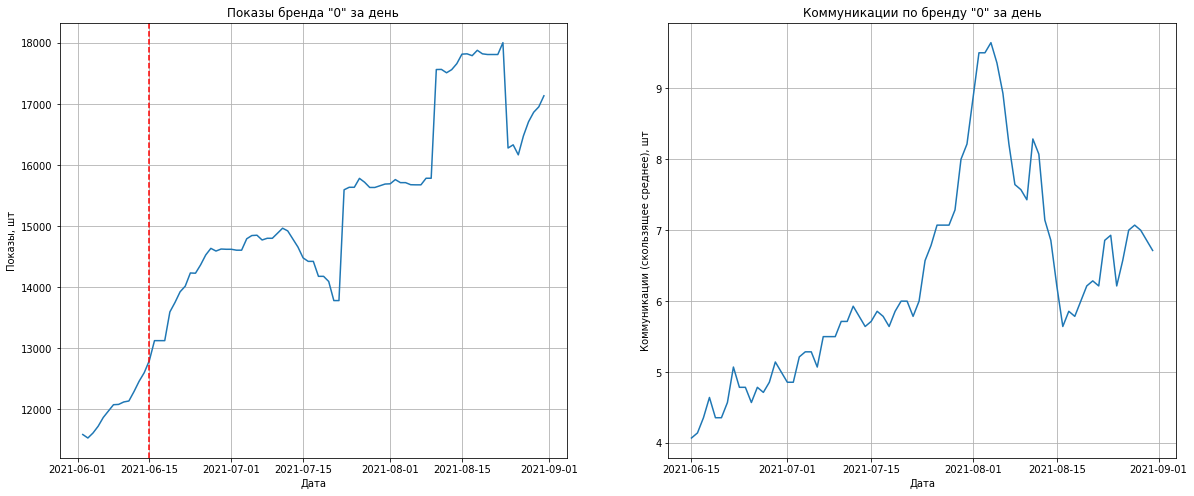

In [38]:
# графики
fig, ax =plt.subplots(1,2)
sns.lineplot(data=df_0, x="date", y='sum_shows', ax=ax[0])
sns.lineplot(data=df_0, x="date", y='filtered_communication_count', ax=ax[1])
fig.set_figheight(8)
fig.set_figwidth(20)


# красота
ax[0].set_title('Показы бренда "0" за день')
ax[0].set_xlabel('Дата')
ax[0].set_ylabel('Показы, шт')
ax[0].grid(True)
ax[0].axvline(pd.to_datetime('2021-06-15'), c = 'red', linestyle = '--')
ax[1].set_title('Коммуникации по бренду "0" за день')
ax[1].set_xlabel('Дата')
ax[1].set_ylabel('Коммуникации (скользящее среднее), шт')
ax[1].grid(True)



plt.show()

Так как из за сглаживания мы теряем часть данных, красной линиией показано откуда можно смотреть график количества показов

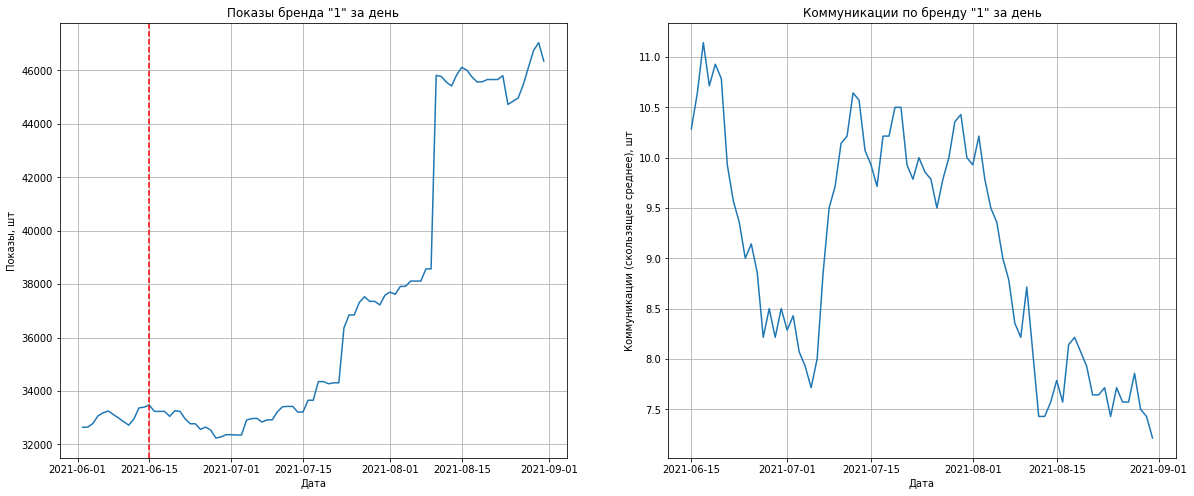

In [39]:
# графики
fig, ax =plt.subplots(1,2)
sns.lineplot(data=df_1, x="date", y='sum_shows', ax=ax[0])
sns.lineplot(data=df_1, x="date", y='filtered_communication_count', ax=ax[1])
fig.set_figheight(8)
fig.set_figwidth(20)


# красота
ax[0].set_title('Показы бренда "1" за день')
ax[0].set_xlabel('Дата')
ax[0].set_ylabel('Показы, шт')
ax[0].grid(True)
ax[1].set_title('Коммуникации по бренду "1" за день')
ax[1].set_xlabel('Дата')
ax[1].set_ylabel('Коммуникации (скользящее среднее), шт')
ax[1].grid(True)
ax[0].axvline(pd.to_datetime('2021-06-15'), c = 'red', linestyle = '--')


plt.show()

## Выводы из графиков
* Для бренда 0 - при повышении количества показов количество коммуникаций увеличивается
* Для бренда 1 - при повышении количества показов количество коммуникаций уменьшается

# Построение матрицы корреляции

## Проверка данных на нормальность 

Для всех статистических тестов мы принимаем пороговое значение 0,05

In [40]:
alpha = 0.05
for i in range(2):
  for val in ['sum_shows','communication_count']:
        stat,p = shapiro(df[df['brand_id'] == i][val])
        if p > alpha : print(f'Величина {val} бренда "{i}" распределена нормально')
        else : print(f'Величина {val} бренда "{i}" распределена не нормально')

Величина sum_shows бренда "0" распределена не нормально
Величина communication_count бренда "0" распределена не нормально
Величина sum_shows бренда "1" распределена не нормально
Величина communication_count бренда "1" распределена не нормально


Ни одна из исследуемых величин не распределена нормально, для оценки корреляции будет применён коэффициент корреляции Спирмана.

## Расчёт коэффициента корреляции Спирмана

Сформулируем гипотезы: <br>
H0 - между величинами нет корреляции <br>
H1 - между величинами есть корреляция

In [41]:
# рассчитаем коэффициент корреляции и уровень значимости
rho, p = spearmanr(df[df['brand_id']==0]['sum_shows'], df[df['brand_id']==0]['communication_count'])

#напечатаем кранговая корреляция Спирмена и p-значение
print(f'Коэффициент корреляции для бренда "0" {rho}. Уровень значимости {p}')
if p > alpha:
  print(f'Между величинами нет корреляции (не удалось отклонить Н0) p = {p:.2f}')
else:
  print(f'Между величинами есть корреляция, коэффициент корреляци равен {rho:.2f} (отклоняем Н0), p = {p:.2f}')

Коэффициент корреляции для бренда "0" 0.2465977743015917. Уровень значимости 0.019127447267796888
Между величинами есть корреляция, коэффициент корреляци равен 0.25 (отклоняем Н0), p = 0.02


In [42]:
# рассчитаем коэффициент корреляции и уровень значимости
rho, p = spearmanr(df[df['brand_id']==1]['sum_shows'], df[df['brand_id']==1]['communication_count'])

#напечатаем кранговая корреляция Спирмена и p-значение
print(f'Коэффициент корреляции для бренда "1" {rho}. Уровень значимости {p}')
if p > alpha:
  print(f'Между величинами нет корреляции (не удалось отклонить Н0) p = {p:.2f}')
else:
  print(f'Между величинами есть корреляция, коэффициент корреляции равен {rho:.2f} (отклоняем Н0), p = {p:.2f}')


Коэффициент корреляции для бренда "1" -0.15081710857673805. Уровень значимости 0.15358234403948887
Между величинами нет корреляции (не удалось отклонить Н0) p = 0.15


## Выводы по корреляции
* Для бренда "0" между количеством показов и коммуникаций есть корреляция, коэффициент корреляции равен 0.25 (отклоняем Н0), уровень значимости p = 0.02
* Для бренда "1" между количеством показов и коммуникаций нет корреляции (не удалось отклонить Н0) p = 0.15

# Построение матрицы корреляции "PHIK"

In [43]:
phik_overview = df[df['brand_id'] == 1].phik_matrix()
phik_overview

interval columns not set, guessing: ['brand_id', 'sum_shows', 'communication_count']


/usr/local/lib/python3.8/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable brand_id for analysis 1. Dropping this column
  warnings.warn(


,date,sum_shows,communication_count
date,1.0,1.0,1.0
sum_shows,1.0,1.0,0.0
communication_count,1.0,0.0,1.0


К сожалению phik не оправдал себя и не показал наличие корреляции

# Расчёт конверсии по дням

В наших данных о коммуникациях нет информаци о влиянии конкретной ключевой фразы на коммуникацию, попробуем сравнить график частотности ключевых фраз и конверсии

In [44]:
df['dayli_ctr'] = df['communication_count']/df['sum_shows']*100
df.head(10)

<ipython-input-44-54605f473f63>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayli_ctr'] = df['communication_count']/df['sum_shows']*100


,date,brand_id,sum_shows,communication_count,dayli_ctr
2,2021-06-02,0,11590.0,5.0,0.043141
3,2021-06-02,1,32641.0,7.0,0.021445
4,2021-06-03,0,11533.0,5.0,0.043354
5,2021-06-03,1,32649.0,9.0,0.027566
6,2021-06-04,0,11615.0,2.0,0.017219
7,2021-06-04,1,32784.0,13.0,0.039653
8,2021-06-05,0,11725.0,6.0,0.051173
9,2021-06-05,1,33072.0,3.0,0.009071
10,2021-06-06,0,11869.0,2.0,0.016851
11,2021-06-06,1,33185.0,9.0,0.027121


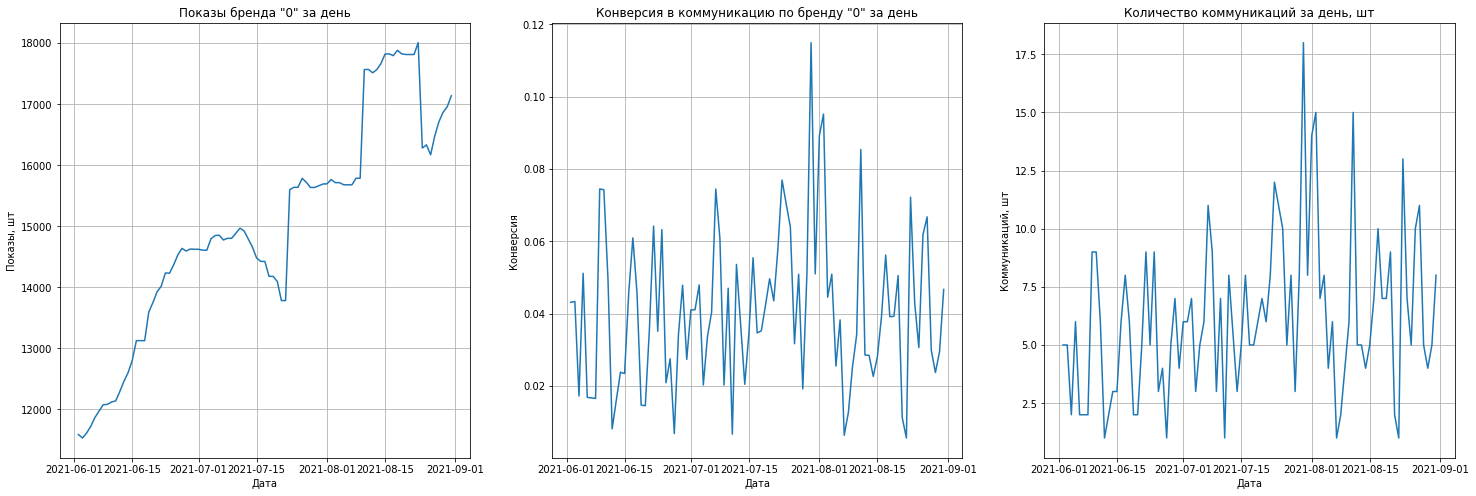

In [45]:
# графики
fig, ax =plt.subplots(1,3)
sns.lineplot(data=df[df['brand_id'] == 0], x="date", y='sum_shows', ax=ax[0])
sns.lineplot(data=df[df['brand_id'] == 0], x="date", y='dayli_ctr', ax=ax[1])
sns.lineplot(data=df[df['brand_id'] == 0], x="date", y='communication_count', ax=ax[2])
fig.set_figheight(8)
fig.set_figwidth(25)


# красота
ax[0].set_title('Показы бренда "0" за день')
ax[0].set_xlabel('Дата')
ax[0].set_ylabel('Показы, шт')
ax[0].grid(True)
ax[1].set_title('Конверсия в коммуникацию по бренду "0" за день')
ax[1].set_xlabel('Дата')
ax[1].set_ylabel('Конверсия')
ax[1].grid(True)
ax[2].set_title('Количество коммуникаций за день, шт')
ax[2].set_xlabel('Дата')
ax[2].set_ylabel('Коммуникаций, шт')
ax[2].grid(True)



plt.show()

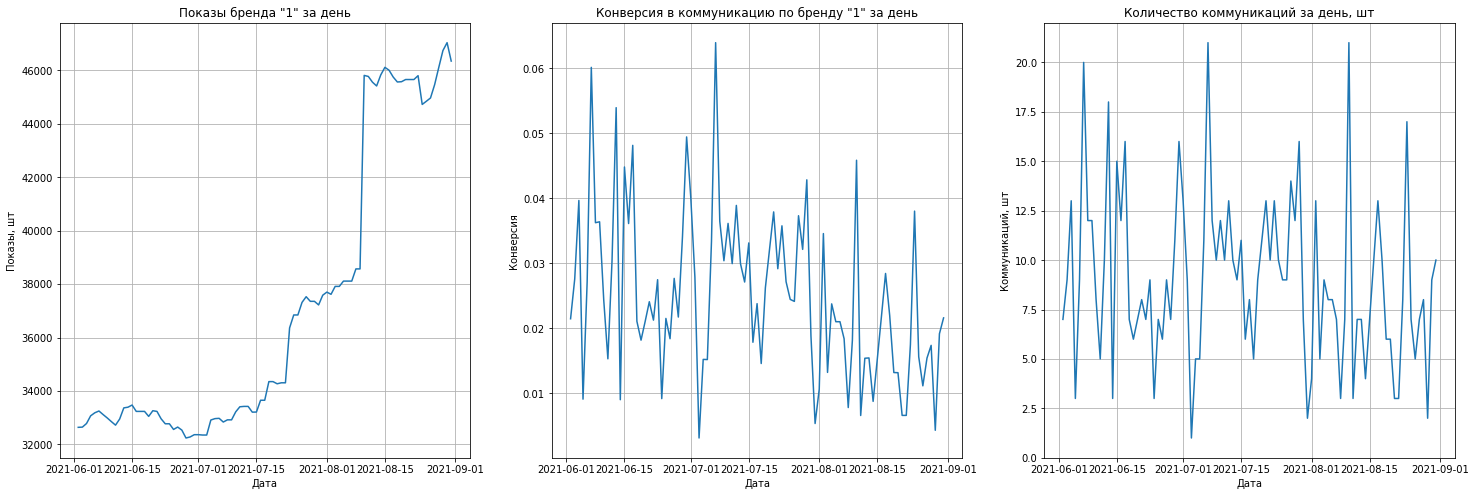

In [46]:
# графики
fig, ax =plt.subplots(1,3)
sns.lineplot(data=df[df['brand_id'] == 1], x="date", y='sum_shows', ax=ax[0])
sns.lineplot(data=df[df['brand_id'] == 1], x="date", y='dayli_ctr', ax=ax[1])
sns.lineplot(data=df[df['brand_id'] == 1], x="date", y='communication_count', ax=ax[2])
fig.set_figheight(8)
fig.set_figwidth(25)


# красота
ax[0].set_title('Показы бренда "1" за день')
ax[0].set_xlabel('Дата')
ax[0].set_ylabel('Показы, шт')
ax[0].grid(True)
ax[1].set_title('Конверсия в коммуникацию по бренду "1" за день')
ax[1].set_xlabel('Дата')
ax[1].set_ylabel('Конверсия')
ax[1].grid(True)
ax[2].set_title('Количество коммуникаций за день, шт')
ax[2].set_xlabel('Дата')
ax[2].set_ylabel('Коммуникаций, шт')
ax[2].grid(True)


plt.show()

График конверсии повторяет график количества коммуникаций, новых выводов сделать не удалось.

#Общие выводы и рекомендации

В рамках нашего исследования мы проанализировали количество показов и коммуникаций по двум брендам за 3 месяца. Мы загрузили данные с удаленного сервера и файла из электронной почты. В данных не были обнаружены пропуски и аномалии. Мы посчитали суммарное количество коммуникаций по брендам по дням и суммарное количество показов по брендам по дням, на основании этих данных мы построили графики и посчитали коэффициенты корреляции. На основании графиков мы сделали следующие выводы:
*   По обоим брендам наблюдаем рост показов органической выдачи
*   По обоим брендам наблюдаем резкие скачки показов органической выдачи, возможно они вызваны рекламными кампаниями брендов, анонсами новых моделей или другими действиями повышающими интерес к бренду
* по некоторым поисковым фразам наблюдаются резкие скачки частотности (например 8)
* по бренду "1" частотность запросов выше примерно в 2 раза (чем по бренду "0")
* по обоим брендам есть высокочастотные запросы, отличающиеся от остальных по частотности в 4-5 раз ( 7 и 44 )
* у бренда "0" 17 поисковых фраз, а у бренда "1" - 30 
* По графикам количества коммуникаций наблюдаем шум, из за этого сложно было сначала оценить тренд, для этого мы применили метод скользящего среднего
* Для бренда "0" между количеством показов и коммуникаций есть корреляция, коэффициент корреляции равен 0.25, уровень значимости p = 0.02
* Для бренда "1" между количеством показов и коммуникаций нет корреляции p = 0.15


По итогам мы сформулировали 2 гипотезы:
*  при поиске информации по бренду "1" пользователи наталкиваются на какую то информацию, препятствующую созданию коммуникаций. Есть шанс, что бренд 1 ушел из РФ, что повысило его поисковую выдачу, однако сам уход и отсутствие автомобилей не позволило увеличить количество коммуникаций. Рекомендуем проанализировать поисковую выдачу органических запросов по бренду 1 и определить, как она может влиять на коммуникацию. 
* падение количества коммуникаций связано с нарушением в самом механизме создания коммуникации ( если у нас речь идет об одном канале). Например имел место какой то технический сбой - ошибка на сайте, в форме заявки или человеческий фактор - например директор приказал не обрабатывать заявки по данному бренду, машин данного бренда не было в наличии и запись в базе не создавалась.

In [47]:
# список библиотек для requirements.txt
!pip freeze requirements.txt

absl-py==1.3.0
aeppl==0.0.33
aesara==2.7.9
aiohttp==3.8.3
aiosignal==1.3.1
alabaster==0.7.12
albumentations==1.2.1
altair==4.2.0
appdirs==1.4.4
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.1.0
audioread==3.0.0
autograd==1.5
Babel==2.11.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.9
bokeh==2.3.3
branca==0.6.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==5.2.0
catalogue==2.0.8
certifi==2022.9.24
cffi==1.15.1
cftime==1.6.2
chardet==3.0.4
charset-normalizer==2.1.1
click==7.1.2
clikit==0.6.2
cloudpickle==1.5.0
cmake==3.22.6
cmdstanpy==1.0.8
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.3
cons==0.4.5
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.2.2
cycler==0.11.0
cymem==2.0.7
Cython==0.29.32
daft==0.0.4
dask==2022.2.0
datascience==0.17.5
db-dtypes==1.0.4
debugpy==1.0.